<a href="https://www.kaggle.com/code/prashantdubey2107/notebookb988b3b9a2?scriptVersionId=249418264" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bitcoin-price-trends-with-indicators-8-years/btc_2015_2024.csv
/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_1h_data_2018_to_2025.csv
/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_15m_data_2018_to_2025.csv
/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_4h_data_2018_to_2025.csv
/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_1d_data_2018_to_2025.csv
/kaggle/input/bitcoin-price-prediction-updated-daily/__results__.html
/kaggle/input/bitcoin-price-prediction-updated-daily/__notebook__.ipynb
/kaggle/input/bitcoin-price-prediction-updated-daily/__output__.json
/kaggle/input/bitcoin-price-prediction-updated-daily/custom.css
/kaggle/input/bitcoin-price-prediction-updated-daily/__results___files/__results___67_0.png
/kaggle/input/bitcoin-price-prediction-updated-daily/__results___files/__results___28_1.png
/kaggle/input/bitcoin-price-prediction-updated-daily/__results___files/__results___66_0.png
/kaggle/input/bitcoin-price-prediction-updated-

Feature columns: ['open', 'high', 'low', 'volume']
RMSE: 103.41
R² Score: 1.0000


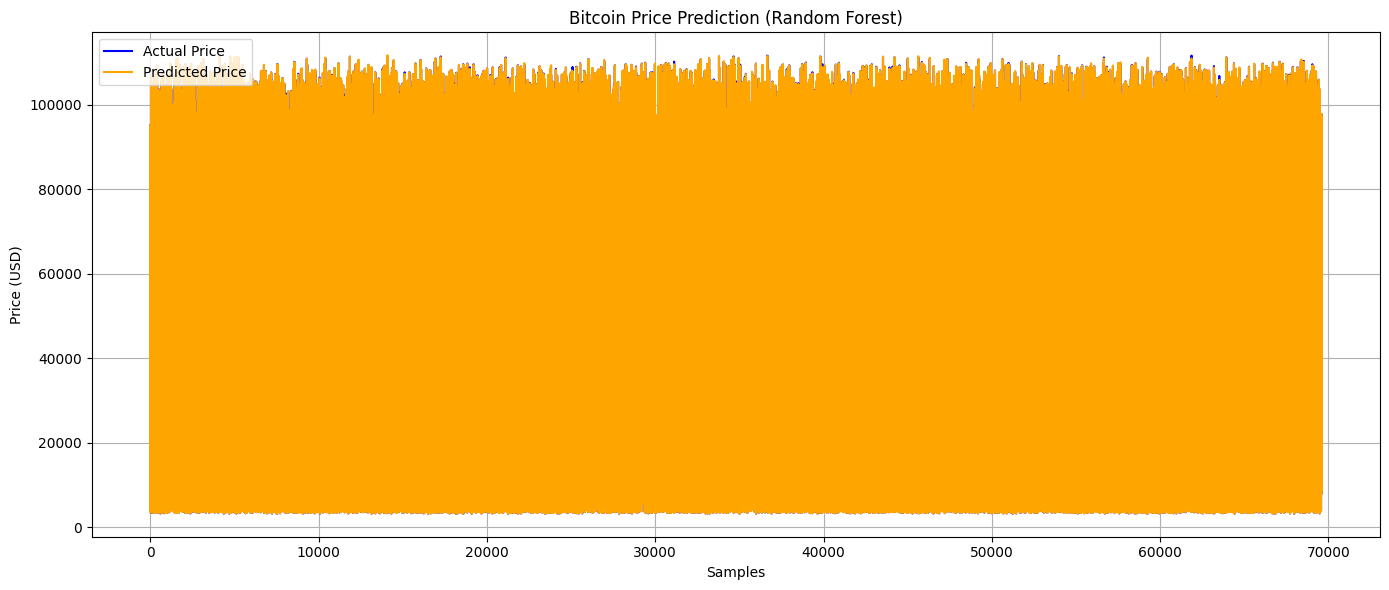


Classification Report (Direction Up/Down):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12515
           1       0.76      0.77      0.77      1410

    accuracy                           0.95     13925
   macro avg       0.87      0.87      0.87     13925
weighted avg       0.95      0.95      0.95     13925



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import joblib
import warnings

warnings.filterwarnings("ignore")


paths = [
    "/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_15m_data_2018_to_2025.csv",
    "/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_1h_data_2018_to_2025.csv",
    "/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_4h_data_2018_to_2025.csv",
    "/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_1d_data_2018_to_2025.csv"
]

dfs = [pd.read_csv(p) for p in paths]
btc_df = pd.concat(dfs, ignore_index=True)


btc_df.columns = btc_df.columns.str.lower()
btc_df['open time'] = pd.to_datetime(
    btc_df['open time'].str.replace(" UTC", "", regex=False),
    format='mixed',
    errors='coerce'
)
btc_df = btc_df.sort_values('open time')


btc_df = btc_df.drop(columns=[
    'taker buy quote asset volume',
    'taker buy base asset volume',
    'number of trades',
    'quote asset volume',
    'close time',
    'ignore'
], errors='ignore')


btc_df['next_close'] = btc_df['close'].shift(-1)
btc_df['target_updown'] = (btc_df['next_close'] > btc_df['close']).astype(int)
btc_df.dropna(inplace=True)


features = btc_df[['open', 'high', 'low', 'volume']]
target = btc_df['close']


X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)


joblib.dump(model, 'model_btc_e.pkl')


y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Feature columns:", list(features.columns))
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label="Actual Price", color='blue')
plt.plot(y_pred, label="Predicted Price", color='orange')
plt.title("Bitcoin Price Prediction (Random Forest)")
plt.xlabel("Samples")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




btc_test = features.iloc[y_test.index].copy()
btc_test['actual_close'] = y_test
btc_test['predicted_close'] = y_pred


btc_test['actual_direction'] = (btc_test['actual_close'] > btc_test['actual_close'].shift(1)).astype(int)
btc_test['predicted_direction'] = (btc_test['predicted_close'] > btc_test['actual_close'].shift(1)).astype(int)

btc_test.dropna(inplace=True)

print("\nClassification Report (Direction Up/Down):")
print(classification_report(btc_test['actual_direction'], btc_test['predicted_direction']))
